In [1]:
# Some help with boilerplate code taken from Claude 3.5

import torch
from torch import optim
from torch.utils.data import Subset, Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from tqdm import tqdm
from datetime import datetime

from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
# req torch, torchvision, einops, tqdm, ema_pytorch, accelerate
from IPython.display import display
from tqdm import tqdm

import glob

import os
CWD = os.getcwd()

# Device stuff
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Remember to use {device} device from here on")

%cd /home/physics/phuqza/E9/DDPM-HL-LHC/
from DDPMLHC.config import *
from DDPMLHC.calculate_quantities import *
from DDPMLHC.data_loading import *
from DDPMLHC.generate_plots.overlaid_1d import create_overlay_plots
from DDPMLHC.generate_plots.bmap import save_to_bmap

/home/physics/phuqza/E9/DDPM-HL-LHC/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/physics/phuqza/E9/DDPM-HL-LHC/venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


CUDA available: True
GPU Device: NVIDIA RTX A4000
Number of GPUs: 1
Remember to use cuda device from here on
/home/physics/phuqza/E9/DDPM-HL-LHC


In [2]:
def show_tensor_images(tensor_images):
    to_pil = T.ToPILImage()
    pil_images = [to_pil(image) for image in tensor_images]

    for img in pil_images:
        display(img)

In [3]:
test_model = Unet(
    dim=64,                  # Base dimensionality of feature maps
    dim_mults=(1, 2, 4, 8),  # Multipliers for feature dimensions at each level
    channels=3,              # E.g. 3 for RGB
).to(device)

test_diffusion = GaussianDiffusion(
    model=test_model,
    image_size=128,              # Side bins
    timesteps=1000,              # Number of diffusion steps
    sampling_timesteps=250,      # Number of steps during sampling (can be less than timesteps)
    objective='pred_v',
).to(device)

training_images = torch.rand(8, 3, 128, 128).to(device) # images are normalized from 0 to 1
loss = test_diffusion(training_images)
loss.backward()

sampling loop time step: 100%|██████████| 250/250 [00:05<00:00, 44.70it/s]


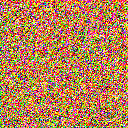

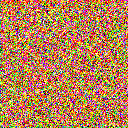

In [4]:
sampled_images = test_diffusion.sample(batch_size = 2)
sampled_images.shape # (4, 3, 128, 128)
show_tensor_images(sampled_images)

In [5]:
class CatOnlyDataset(Dataset):
    def __init__(self, root=f"{CWD}/data/ML", train=True, transform=None):
        self.transform = transform
        self.cifar = CIFAR10(root=root, train=train, download=True)
        self.cat_indices = [i for i, (_, label) in enumerate(self.cifar) if label == 3]  # Class 3 is cat

    def __len__(self):
        return len(self.cat_indices)

    def __getitem__(self, idx):
        image, _ = self.cifar[self.cat_indices[idx]
        if self.transform:
            image = self.transform(image)
        return image

transform = T.Compose([
    T.Resize(128),
    T.ToTensor(),
])

cat_dataset = CatOnlyDataset(transform=transform)
test_dataloader = DataLoader(cat_dataset, batch_size=16, shuffle=True, num_workers=4)
print(len(test_dataloader))

Files already downloaded and verified
313


In [6]:
# Function to load last checkpoint and train the model
def load_and_train(
    diffusion,
    dataloader,
    num_epochs,
    device,
    save_dir,
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Get last epoch number
    checkpoint_files = glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth'))
    last_epoch = 0
    if checkpoint_files:
        epoch_numbers = []
        for f in checkpoint_files:
            try:
                epoch_num = int(f.split('epoch_')[1].split('_loss')[0])
                epoch_numbers.append(epoch_num)
            except:
                continue
        last_epoch = max(epoch_numbers) if epoch_numbers else 0

    # Load checkpoint if exists
    if last_epoch > 0:
        checkpoint_pattern = os.path.join(save_dir, f'checkpoint_epoch_{last_epoch}_*.pth')
        checkpoint_file = glob.glob(checkpoint_pattern)[0]
        print(f"Loading checkpoint: {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        diffusion.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Starting fresh training")

    optimizer = optim.Adam(diffusion.parameters(), lr=1e-4)

    for epoch in range(last_epoch, last_epoch + num_epochs):
        print(f"\nEpoch {epoch + 1}/{last_epoch + num_epochs}")
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

        running_loss = 0.0
        for i, images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (i + 1)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})

        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{avg_loss:.4f}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': diffusion.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')


In [7]:
save_dir = f"{CWD}/data/ML/first"
num_epochs = 1
load_and_train(test_diffusion, test_dataloader, num_epochs=num_epochs, device=device, save_dir=save_dir)

Loading checkpoint: /home/physics/phuqza/E9/DDPM-HL-LHC/data/ML/first/checkpoint_epoch_65_loss_0.0070.pth

Epoch 66/66


/tmp/ipykernel_189910/1990470036.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=device)
100%|██████████| 313/313 

Checkpoint saved: /home/physics/phuqza/E9/DDPM-HL-LHC/data/ML/first/checkpoint_epoch_66_loss_0.0069.pth


sampling loop time step: 100%|██████████| 250/250 [00:09<00:00, 25.98it/s]


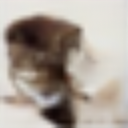

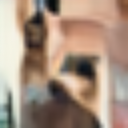

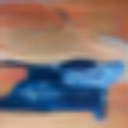

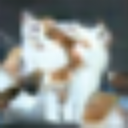

In [8]:
test_model.eval()
test_diffusion.eval()

sampled_images = test_diffusion.sample(batch_size=4)
show_tensor_images(sampled_images)
save_image(sampled_images, f"{CWD}/data", nrow=2, normalize=True)